In [1]:
import pandas as pd
import allel
import seaborn as sns

In [2]:
cam5_annot = pd.read_csv('cam5_annot.csv')

In [3]:
clim1001 = pd.read_csv('../key_files/1001g_regmap_grenet_ecotype_info_corrected_bioclim_2024May16.csv')

In [4]:
clim1001['ecotypeid'] = clim1001['ecotypeid'].astype(str)

In [5]:
ecotypeid_to_bio1 = clim1001.set_index('ecotypeid')['bio1'].to_dict()

In [5]:
import subprocess

command = """
grep "^#" ../gwas/1001g/1001g_grenet_climate.recode.vcf > filtered_cam5_1001g.vcf && \
grep "^2\s" ../gwas/1001g/1001g_grenet_climate.recode.vcf | \
awk '$2 >= 11531967 && $2 <= 11534358' >> filtered_cam5_1001g.vcf
"""

# Run the command in a bash shell
subprocess.run(command, shell=True, executable='/bin/bash')

CompletedProcess(args='\ngrep "^#" ../gwas/1001g/1001g_grenet_climate.recode.vcf > filtered_cam5_1001g.vcf && grep "^2\\s" ../gwas/1001g/1001g_grenet_climate.recode.vcf | awk \'$2 >= 11531967 && $2 <= 11534358\' >> filtered_cam5_1001g.vcf\n', returncode=0)

In [12]:
command = """
zgrep "^#" ../gwas/greneNet_final_v1.1.recode.vcf.gz> filtered_cam5_grenenet.vcf && \
zgrep "^2\s" ../gwas/greneNet_final_v1.1.recode.vcf.gz | \
awk '$2 >= 11531967 && $2 <= 11534358' >> filtered_cam5_grenenet.vcf
"""

# Run the command in a bash shell
subprocess.run(command, shell=True, executable='/bin/bash')

CompletedProcess(args='\nzgrep "^#" ../gwas/greneNet_final_v1.1.recode.vcf.gz> filtered_cam5_grenenet.vcf && zgrep "^2\\s" ../gwas/greneNet_final_v1.1.recode.vcf.gz | awk \'$2 >= 11531967 && $2 <= 11534358\' >> filtered_cam5_grenenet.vcf\n', returncode=0)

In [ ]:
# Convert start and end into an IntervalIndex
exons_utr_df['interval'] = pd.IntervalIndex.from_arrays(exons_utr_df['start'], exons_utr_df['end'], closed='both')

# Set the IntervalIndex as the index of the DataFrame
exons_utr_df.set_index('interval', inplace=True)

In [194]:
vcf1001 = allel.read_vcf('filtered_cam5_1001g.vcf')

geno = vcf1001['calldata/GT']

geno = geno.sum(axis=2)

geno = pd.DataFrame(geno)

geno.columns = vcf1001['samples']

g1001_chrom_pos = pd.DataFrame({'chrom': vcf1001['variants/CHROM'], 'pos': vcf1001['variants/POS']})

vcf1001 = pd.concat([g1001_chrom_pos, geno],axis=1)

In [195]:
vcf_1001_cam5annot = cam5_annot.merge(vcf1001, on = 'pos')

vcf_1001_cam5annot = vcf_1001_cam5annot.drop('chrom_x',axis=1)

bios_maped = vcf_1001_cam5annot.columns[5:].map(ecotypeid_to_bio1)

new_columns = ['pos', 'EFF', 'LOF', 'NMD', 'chrom_y'] + bios_maped.tolist()

vcf_1001_cam5annot.columns = new_columns

eff_columns = vcf_1001_cam5annot['EFF'].str.split('|', expand=True)

eff_columns.columns = ['Effect', 'Impact', 'Position', 'Change', 'Gene', 'Biotype', 'Rank', 'HGVS.c', 'HGVS.p', 'cdna_pos', 'Other']

eff_columns = eff_columns.drop(['Position', 'Change', 'Gene', 'Biotype', 'cdna_pos', 'Other'],axis=1)

vcf_1001_cam5annot = pd.concat([eff_columns, vcf_1001_cam5annot],axis=1)





In [196]:
vcf_1001_cam5annot.loc[(vcf_1001_cam5annot['pos']>= 11533904) & (vcf_1001_cam5annot['pos']<= 11534263), 'block'] = 'sign_block'

In [197]:
vcf_1001_cam5annot[(vcf_1001_cam5annot['pos']>= 11532004) & (vcf_1001_cam5annot['pos']<= 11532068)]

,Effect,Impact,Rank,HGVS.c,HGVS.p,pos,EFF,LOF,NMD,chrom_y,...,8.88749980926514,8.21666622161865,9.11666679382324,15.8291664123535,15.1000003814697,18.3333339691162,13.2791662216187,8.71666717529297,9.88749980926514,block
0,5_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.1,11532055,5_prime_UTR_variant(MODIFIER||14|c.-14A>C|149|...,NaN,NaN,2,...,0,0,0,0,0,0,0,0,0,NaN


In [198]:


exons_utr_df_var1 = exons_utr_df[exons_utr_df['annotation'] == 'Parent=AT2G27030.1']
# Map each SNP position to its corresponding feature type
vcf_1001_cam5annot['feature_type_var1'] = vcf_1001_cam5annot['pos'].apply(
    lambda x: exons_utr_df_var1.loc[exons_utr_df_var1.index.contains(x)]['feature_type'].values[0] if any(exons_utr_df_var1.index.contains(x)) else 'intergenic'
)

exons_utr_df_var2 = exons_utr_df[exons_utr_df['annotation'] == 'Parent=AT2G27030.2']
# Map each SNP position to its corresponding feature type
vcf_1001_cam5annot['feature_type_var2'] = vcf_1001_cam5annot['pos'].apply(
    lambda x: exons_utr_df_var2.loc[exons_utr_df_var2.index.contains(x)]['feature_type'].values[0] if any(exons_utr_df_var2.index.contains(x)) else 'intergenic'
)

exons_utr_df_var3 = exons_utr_df[exons_utr_df['annotation'] == 'Parent=AT2G27030.3']
# Map each SNP position to its corresponding feature type
vcf_1001_cam5annot['feature_type_var3'] = vcf_1001_cam5annot['pos'].apply(
    lambda x: exons_utr_df_var3.loc[exons_utr_df_var3.index.contains(x)]['feature_type'].values[0] if any(exons_utr_df_var3.index.contains(x)) else 'intergenic'
)

# Display the updated DataFrame


In [199]:
vcf_1001_cam5annot.columns

Index([           'Effect',            'Impact',              'Rank',
                  'HGVS.c',            'HGVS.p',               'pos',
                     'EFF',               'LOF',               'NMD',
                 'chrom_y',
       ...
          15.8291664123535,    15.1000003814697,    18.3333339691162,
          13.2791662216187,    8.71666717529297,    9.88749980926514,
                   'block', 'feature_type_var1', 'feature_type_var2',
       'feature_type_var3'],
      dtype='object', length=1151)

In [203]:
vcf_1001_cam5annot['Effect'].unique()

array(['5_prime_UTR_variant(MODIFIER',
       '5_prime_UTR_premature_start_codon_gain_variant(LOW',
       'synonymous_variant(LOW', '3_prime_UTR_variant(MODIFIER',
       'missense_variant(MODERATE', 'upstream_gene_variant(MODIFIER'],
      dtype=object)

In [204]:
for_hm

Effect,5_prime_UTR_variant(MODIFIER,5_prime_UTR_variant(MODIFIER,5_prime_UTR_variant(MODIFIER,5_prime_UTR_variant(MODIFIER,5_prime_UTR_variant(MODIFIER,5_prime_UTR_premature_start_codon_gain_variant(LOW,5_prime_UTR_variant(MODIFIER,5_prime_UTR_premature_start_codon_gain_variant(LOW,5_prime_UTR_premature_start_codon_gain_variant(LOW,5_prime_UTR_variant(MODIFIER,...,missense_variant(MODERATE,missense_variant(MODERATE,synonymous_variant(LOW,synonymous_variant(LOW,missense_variant(MODERATE,3_prime_UTR_variant(MODIFIER,3_prime_UTR_variant(MODIFIER,3_prime_UTR_variant(MODIFIER,3_prime_UTR_variant(MODIFIER,upstream_gene_variant(MODIFIER
8.87916660308838,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10.3583335876465,0,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9.86666679382324,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
11.3208332061768,0,2,0,0,0,0,0,2,2,0,...,0,0,2,0,0,0,0,0,0,0
2.70000004768372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18.3333339691162,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
13.2791662216187,0,2,0,0,0,0,0,0,0,0,...,2,2,2,0,2,0,2,2,0,0
8.71666717529297,0,2,0,0,0,0,0,0,0,0,...,2,2,2,0,2,0,2,2,0,0
9.88749980926514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
vcf_1001_cam5annot['Impact'].unique()

array(['', 'SILENT', 'MISSENSE'], dtype=object)

In [241]:
vcf_1001_cam5annot[vcf_1001_cam5annot['Impact'] != '']

,Effect,Impact,Rank,HGVS.c,HGVS.p,pos,EFF,LOF,NMD,chrom_y,...,15.8291664123535,15.1000003814697,18.3333339691162,13.2791662216187,8.71666717529297,9.88749980926514,block,feature_type_var1,feature_type_var2,feature_type_var3
42,synonymous_variant(LOW,SILENT,protein_coding,CODING,AT2G27030.2,11532790,synonymous_variant(LOW|SILENT|ggT/ggG|p.Gly24G...,NaN,NaN,2,...,0,2,0,0,0,0,NaN,exon,exon,exon
43,synonymous_variant(LOW,SILENT,protein_coding,CODING,AT2G27030.2,11532868,synonymous_variant(LOW|SILENT|ctC/ctG|p.Leu50L...,NaN,NaN,2,...,0,0,2,0,2,0,NaN,exon,exon,exon
44,synonymous_variant(LOW,SILENT,protein_coding,CODING,AT2G27030.2,11532919,synonymous_variant(LOW|SILENT|gcA/gcT|p.Ala67A...,NaN,NaN,2,...,2,0,0,0,2,0,NaN,exon,exon,exon
76,synonymous_variant(LOW,SILENT,protein_coding,CODING,AT2G27030.3,11534092,synonymous_variant(LOW|SILENT|agA/agG|p.Arg154...,NaN,NaN,2,...,0,0,0,0,0,0,sign_block,intergenic,exon,exon
77,missense_variant(MODERATE,MISSENSE,protein_coding,CODING,AT2G27030.3,11534094,missense_variant(MODERATE|MISSENSE|gTt/gCt|p.V...,NaN,NaN,2,...,2,0,0,2,2,0,sign_block,intergenic,exon,exon
78,missense_variant(MODERATE,MISSENSE,protein_coding,CODING,AT2G27030.3,11534099,missense_variant(MODERATE|MISSENSE|Gca/Aca|p.A...,NaN,NaN,2,...,2,0,0,2,2,0,sign_block,intergenic,exon,exon
79,missense_variant(MODERATE,MISSENSE,protein_coding,CODING,AT2G27030.3,11534102,missense_variant(MODERATE|MISSENSE|Gca/Aca|p.A...,NaN,NaN,2,...,2,0,0,2,2,0,sign_block,intergenic,exon,exon
80,synonymous_variant(LOW,SILENT,protein_coding,CODING,AT2G27030.3,11534143,synonymous_variant(LOW|SILENT|aaT/aaC|p.Asn171...,NaN,NaN,2,...,2,0,0,2,2,0,sign_block,intergenic,exon,exon
81,synonymous_variant(LOW,SILENT,protein_coding,CODING,AT2G27030.3,11534161,synonymous_variant(LOW|SILENT|caC/caT|p.His177...,NaN,NaN,2,...,0,0,0,0,0,0,sign_block,intergenic,exon,exon
82,missense_variant(MODERATE,MISSENSE,protein_coding,CODING,AT2G27030.3,11534165,missense_variant(MODERATE|MISSENSE|Cgt/Tgt|p.A...,NaN,NaN,2,...,2,0,0,2,2,0,sign_block,intergenic,exon,exon


In [244]:
vcf_1001_cam5annot = vcf_1001_cam5annot[vcf_1001_cam5annot['block'] == 'sign_block']

In [250]:
for_hm

,-11.49,-11.49,-4.28,-3.27,-3.00,-2.87,-2.49,-1.93,-1.18,0.72,...,17.15,17.17,17.18,17.23,17.70,17.75,17.84,18.33,18.59,22.70
Impact,,,,,,,,,,,,,,,,,,,,,
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,0
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,2


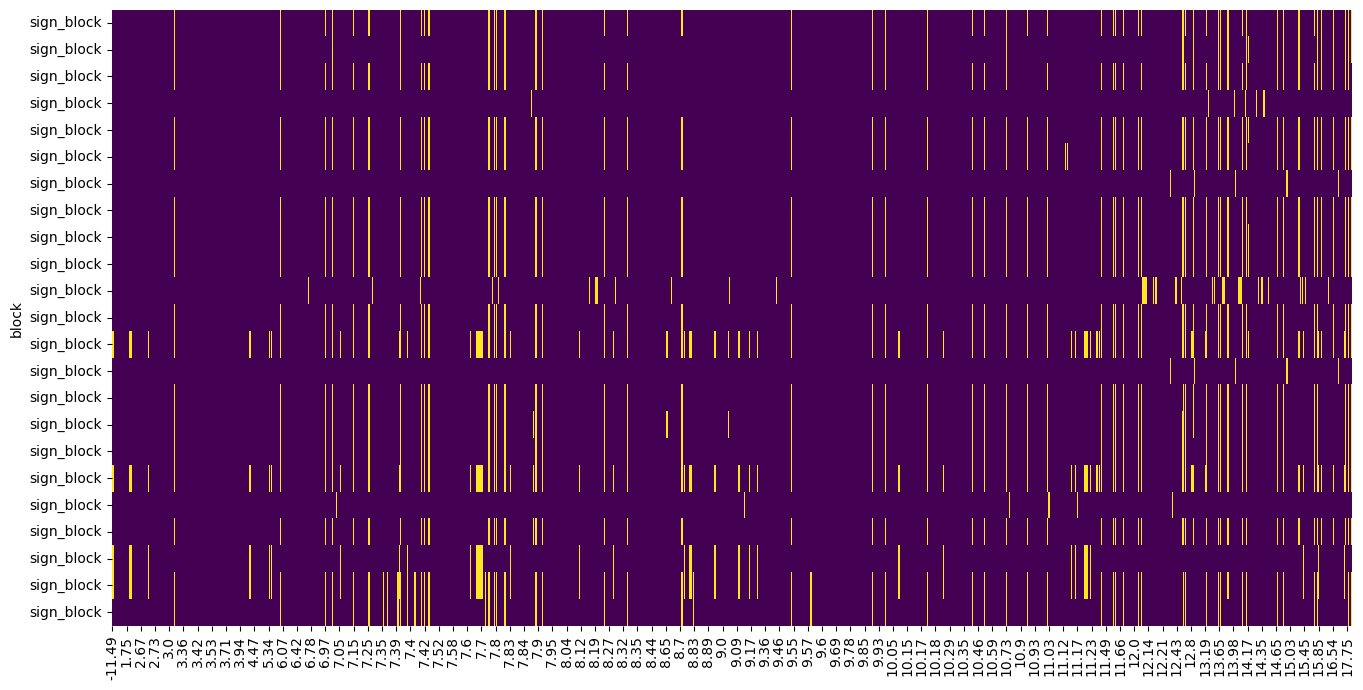

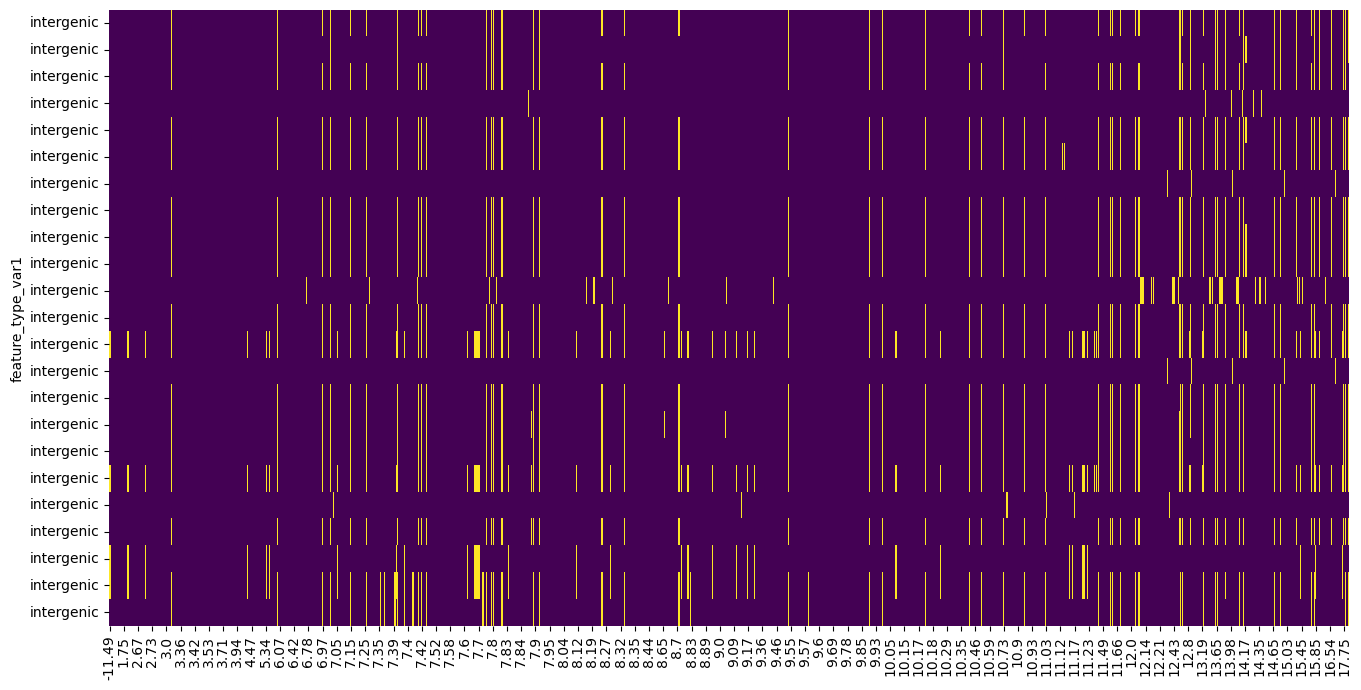

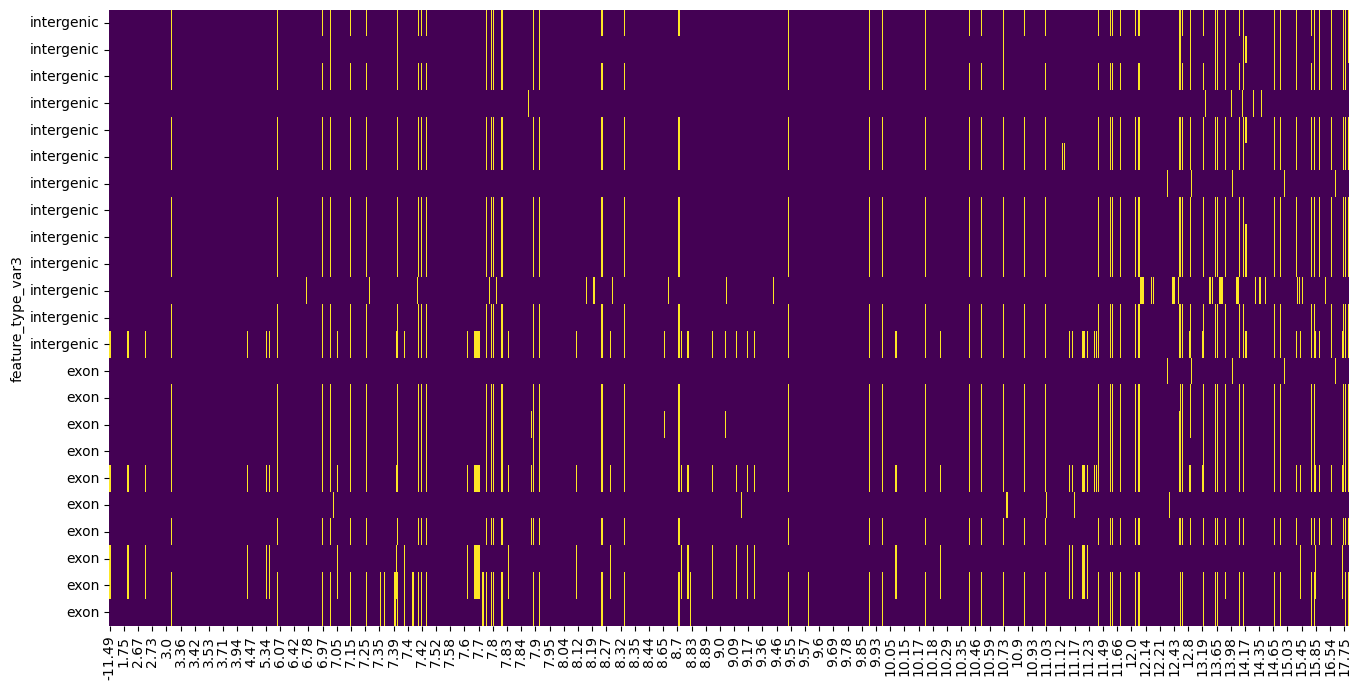

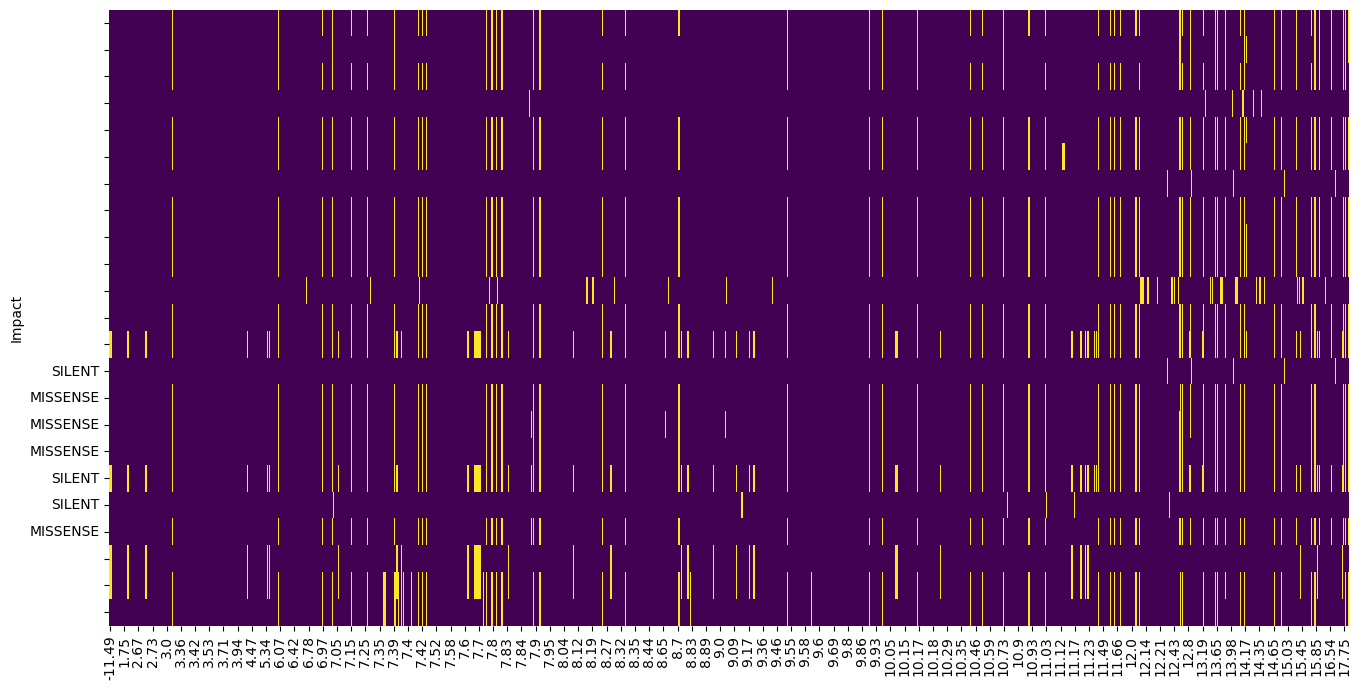

In [253]:
for i in [ 'block', 'feature_type_var1', 'feature_type_var3', 'Impact', ]:  # 'LOF',  'NMD''EFF',  'pos', 'HGVS.c',  'HGVS.p',  'Rank',  'feature_type_var2' 'Effect'
    for_hm = vcf_1001_cam5annot.copy()
    for_hm = for_hm.set_index(i)

    for_hm = for_hm.iloc[:, 10:-4]
    
    for_hm = for_hm.T
    
    for_hm = for_hm.sort_index()
    
    for_hm.index = np.round(for_hm.index.astype(float),2)

    for_hm = for_hm.T

    # Create the heatmap
    plt.figure(figsize=(16, 8))  # Increase the figure size to make the heatmap bigger
    heatmap_plot = sns.heatmap(for_hm, cmap="viridis", cbar=False)
    #plt.savefig(f'heaatmap_1001_g__block{i}.png')
    # Show the plot
    plt.show()

In [235]:
for_hm.

,-11.49,-11.49,-4.28,-3.27,-3.00,-2.87,-2.49,-1.93,-1.18,0.72,...,17.15,17.17,17.18,17.23,17.70,17.75,17.84,18.33,18.59,22.70
Impact,,,,,,,,,,,,,,,,,,,,,
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
,0,0,2,0,0,0,2,0,0,0,...,0,2,2,0,0,0,0,0,2,2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,2,2,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
,2,2,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,2,0,0,2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2


In [216]:
indexes = ['block', 'feature_type_var1', 'feature_type_var3', 'Impact']
for_hm = vcf_1001_cam5annot.set_index(indexes)

In [219]:
for_hm = for_hm.iloc[:, 9:-1].T 

In [225]:
indexes = ['block', 'feature_type_var1', 'feature_type_var3', 'Impact']
for_hm = vcf_1001_cam5annot.set_index(indexes)

# Slice and transpose the DataFrame
for_hm = for_hm.iloc[:, 9:-1].T

In [227]:
# Round the index values
for_hm.index = np.round(for_hm.index.astype(float), 2)

In [229]:
for_hm = for_hm.T

In [232]:
for_hm

9.17   8.88   10.36  \
block      feature_type_var1 feature_type_var3 Impact                        
NaN        exon              exon                          0      0      0   
           intergenic        intergenic                    2      2      2   
                                                           0      0      0   
                                                           0      0      2   
                                                           0      0      0   
...                                                      ...    ...    ...   
sign_block intergenic        exon                          0      0      0   
                                                           0      0      0   
                                                           0      0      0   
NaN        intergenic        exon                          0      0      0   
                             intergenic                    0      0      0   

                                                       9.87   11.32  2.70   \
block      feature_type_var1 feature_type_var3 Impact                        
NaN        exon              exon                          2      0      0   
           intergenic        intergenic                    2      2      0   
                                                           0      0      0   
                                                           0      0      0   
                                                           0      0      0   
...                                                      ...    ...    ...   
sign_block intergenic        exon                          0      0      0   
                                                           0      0      0   
                                                           0      0      0   
NaN        intergenic        exon                          0      0      0   
                             intergenic                    2      0      0   

                                                       2.70   2.70   7.70   \
block      feature_type_var1 feature_type_var3 Impact                        
NaN        exon              exon                          0      0      0   
           intergenic        intergenic                    0      0      0   
                                                           0      0      0   
                                                           0      0      0   
                                                           0      0      0   
...                                                      ...    ...    ...   
sign_block intergenic        exon                          0      2      2   
                                                           0      2      2   
                                                           0      0      0   
NaN        intergenic        exon                          0      0      0   
                             intergenic                    0      0      0   

                                                       13.72  ...  8.29   \
block      feature_type_var1 feature_type_var3 Impact         ...          
NaN        exon              exon                          0  ...      0   
           intergenic        intergenic                    0  ...      2   
                                                           0  ...      0   
                                                           0  ...      0   
                                                           0  ...      0   
...                                                      ...  ...    ...   
sign_block intergenic        exon                          0  ...      0   
                                                           0  ...      0   
                                                           0  ...      0   
NaN        intergenic        exon                          0  ...      0   
                             intergenic                    0  ...      0   

                     

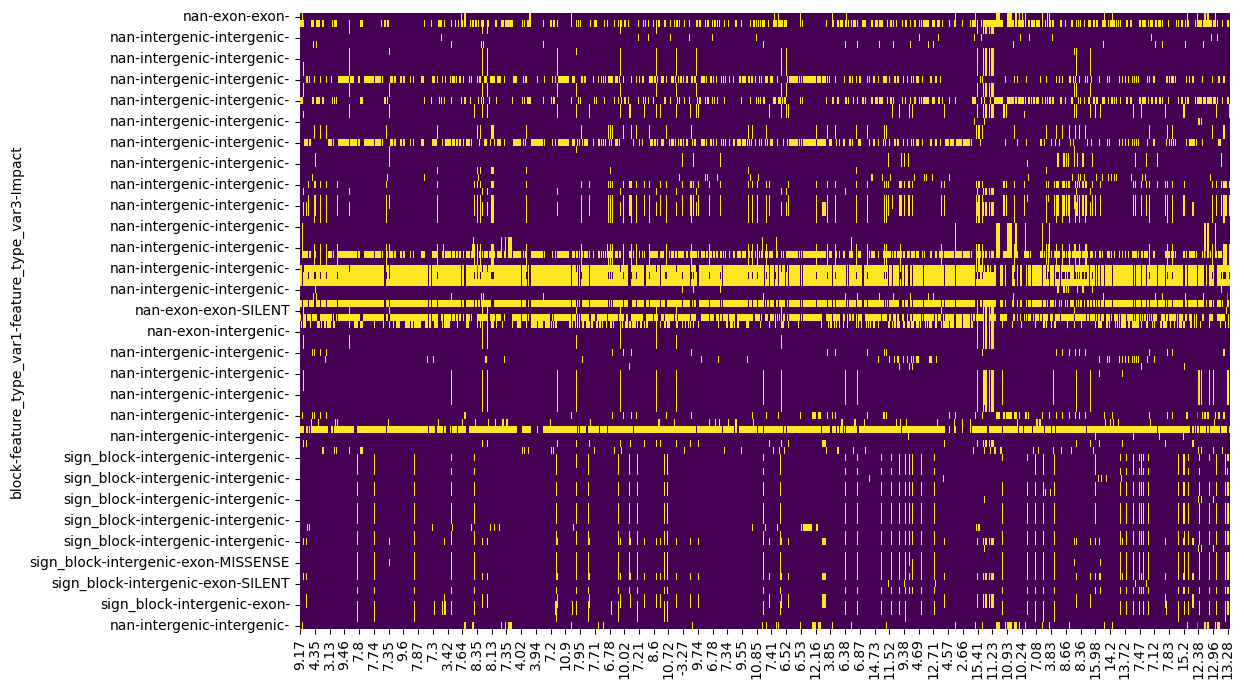

In [231]:
plt.figure(figsize=(12, 8))  # Increase the figure size to make the heatmap bigger
heatmap_plot = sns.heatmap(for_hm, cmap="viridis", cbar=False)

# Show the plot
plt.show()

In [258]:
vcfgrene = allel.read_vcf('filtered_cam5_grenenet.vcf')

geno = vcfgrene['calldata/GT']

geno = geno.sum(axis=2)

geno = pd.DataFrame(geno)

geno.columns = vcfgrene['samples']

grene_chrom_pos = pd.DataFrame({'chrom': vcfgrene['variants/CHROM'], 'pos': vcfgrene['variants/POS']})

vcfgrene = pd.concat([grene_chrom_pos, geno],axis=1)

In [259]:
vcf_grene_cam5annot = cam5_annot.merge(vcfgrene, on = 'pos')

vcf_grene_cam5annot = vcf_grene_cam5annot.drop('chrom_x',axis=1)

bios_maped = vcf_grene_cam5annot.columns[5:].map(ecotypeid_to_bio1)

new_columns = ['pos', 'EFF', 'LOF', 'NMD', 'chrom_y'] + bios_maped.tolist()

vcf_grene_cam5annot.columns = new_columns

eff_columns = vcf_grene_cam5annot['EFF'].str.split('|', expand=True)

eff_columns.columns = ['Effect', 'Impact', 'Position', 'Change', 'Gene', 'Biotype', 'Rank', 'HGVS.c', 'HGVS.p', 'cdna_pos', 'Other']

eff_columns = eff_columns.drop(['Position', 'Change', 'Gene', 'Biotype', 'cdna_pos', 'Other'],axis=1)

vcf_grene_cam5annot = pd.concat([eff_columns, vcf_grene_cam5annot],axis=1)





In [260]:
vcf_grene_cam5annot

,Effect,Impact,Rank,HGVS.c,HGVS.p,pos,EFF,LOF,NMD,chrom_y,...,14.0249996185303,13.8125,8.71666717529297,8.38749980926514,15.8291664123535,15.1000003814697,18.3333339691162,13.2791662216187,8.71666717529297,9.88749980926514
0,5_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.1,11532055,5_prime_UTR_variant(MODIFIER||14|c.-14A>C|149|...,NaN,NaN,2,...,0,0,0,2,0,0,0,0,0,0
1,5_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.2,11532148,5_prime_UTR_variant(MODIFIER||571|c.-571C>A|11...,NaN,NaN,2,...,2,2,2,2,0,0,0,2,0,0
2,5_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.2,11532152,5_prime_UTR_variant(MODIFIER||567|c.-567T>C|11...,NaN,NaN,2,...,0,0,0,0,0,0,0,0,0,0
3,5_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.2,11532162,5_prime_UTR_variant(MODIFIER||557|c.-557C>T|11...,NaN,NaN,2,...,0,0,0,0,0,0,0,2,0,0
4,5_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.2,11532176,5_prime_UTR_variant(MODIFIER||543|c.-543A>G|11...,NaN,NaN,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,3_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.2,11534224,3_prime_UTR_variant(MODIFIER||1164|c.*1164C>T|...,NaN,NaN,2,...,0,0,0,0,0,0,0,0,0,0
84,3_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.2,11534244,3_prime_UTR_variant(MODIFIER||1184|c.*1184T>A|...,NaN,NaN,2,...,0,0,2,0,2,0,0,0,0,0
85,3_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.2,11534263,3_prime_UTR_variant(MODIFIER||1203|c.*1203T>C|...,NaN,NaN,2,...,0,0,2,0,2,0,0,2,0,0
86,3_prime_UTR_variant(MODIFIER,,protein_coding,CODING,AT2G27030.3,11534313,3_prime_UTR_variant(MODIFIER||137|c.*137T>G|18...,NaN,NaN,2,...,0,0,0,0,2,0,0,0,0,0


In [ ]:
for_hm = vcf_grene_cam5annot.set_index('Impact')

In [256]:
for_hm = for_hm.drop(for_hm.columns[:9],axis=1).T

for_hm = for_hm.sort_index()


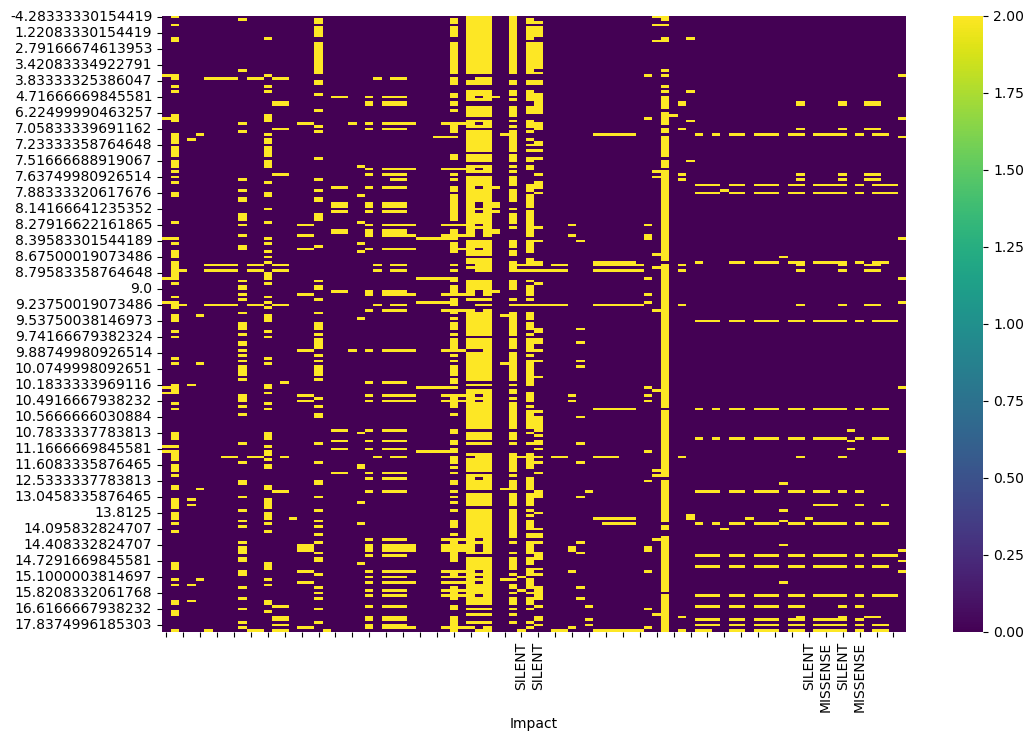

In [257]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `for_hm` is the dataframe you want to plot
plt.figure(figsize=(12, 8))  # Increase the figure size to make the heatmap bigger
sns.heatmap(for_hm, cmap="viridis")
plt.show()

In [242]:
samples = pd.read_csv('../key_files/merged_sample_table.csv')[['site', 'plot', 'generation', 'total_flower_counts']]

samples = samples.groupby(['site', 'plot', 'generation'])['total_flower_counts'].sum().reset_index()

samples['min_perc'] = 1/samples['total_flower_counts']

samples['code'] = samples['site'].astype(str) + '_'  + samples['generation'].astype(str) + '_' + samples['plot'].astype(str) 

ecotype_freq = pd.read_csv('../key_files/merged_ecotype_frequency.txt',sep = '\t')

climate = pd.read_csv('../key_files/bioclimvars_experimental_sites_era5.csv')[['site', 'bio1']]

In [243]:
grenenet_ecotypes = pd.read_csv('../key_files/founder_ecotype_frequency.txt', sep = '\t',header=None)[0]

ecotype_freq = ecotype_freq.set_index(grenenet_ecotypes)

ecotype_freq = ecotype_freq.T 
ecotype_freq = ecotype_freq.reset_index()
ecotype_freq['generation'] = ecotype_freq['index'].str.split('_').str[1]

In [244]:
ecotype_freq['plot'] = ecotype_freq['index'].str.split('_').str[2]

ecotype_freq['site'] = ecotype_freq['index'].str.split('_').str[0] 

In [245]:
ecotype_freq = ecotype_freq.drop('index', axis=1)

In [246]:
ecotype_freq = ecotype_freq.melt(id_vars = ['plot','site', 'generation'])

In [247]:
ecotype_freq.columns = ['plot','site', 'generation', 'ecotype', 'freq']

In [248]:
clim1001f = clim1001[['ecotypeid', 'bio1']]

In [249]:
#clim1001f = clim1001f[clim1001f['bio1'] > 13]

In [250]:
clim1001f['ecotypeid'] = clim1001f['ecotypeid'].astype(int)

/tmp/ipykernel_1201363/3068168531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim1001f['ecotypeid'] = clim1001f['ecotypeid'].astype(int)


In [251]:
ecotype_freq = ecotype_freq.merge(clim1001f, left_on = 'ecotype', right_on = 'ecotypeid')

In [252]:
ecotype_freq['generation'] = ecotype_freq['generation'].astype(int)

In [253]:
ecotype_freq

,plot,site,generation,ecotype,freq,ecotypeid,bio1
0,1,1,1,10002,0.001811,10002,8.879167
1,2,1,1,10002,0.002972,10002,8.879167
2,3,1,1,10002,0.002207,10002,8.879167
3,4,1,1,10002,0.002224,10002,8.879167
4,5,1,1,10002,0.003074,10002,8.879167
...,...,...,...,...,...,...,...
172090,8,60,1,9992,0.000657,9992,9.887500
172091,9,60,1,9992,0.000834,9992,9.887500
172092,10,60,1,9992,0.037258,9992,9.887500
172093,11,60,1,9992,0.000362,9992,9.887500


In [254]:
result = ecotype_freq.copy()

In [255]:
result

,plot,site,generation,ecotype,freq,ecotypeid,bio1
0,1,1,1,10002,0.001811,10002,8.879167
1,2,1,1,10002,0.002972,10002,8.879167
2,3,1,1,10002,0.002207,10002,8.879167
3,4,1,1,10002,0.002224,10002,8.879167
4,5,1,1,10002,0.003074,10002,8.879167
...,...,...,...,...,...,...,...
172090,8,60,1,9992,0.000657,9992,9.887500
172091,9,60,1,9992,0.000834,9992,9.887500
172092,10,60,1,9992,0.037258,9992,9.887500
172093,11,60,1,9992,0.000362,9992,9.887500


In [256]:
#import os

In [257]:
#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')

In [258]:
clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/worldclim_sitesdata.csv')

In [259]:
clim_sites_during_exp = clim_sites_during_exp[['site', 'bio1']]

In [260]:
clim_sites_during_exp['site'] = clim_sites_during_exp['site'].astype(str)

In [261]:
result.columns = ['plot', 'site', 'generation', 'ecotype', 'freq', 'ecotypeid', 'bio1_ecotype']

In [262]:
result = result.merge(clim_sites_during_exp, on ='site')

In [263]:
result

,plot,site,generation,ecotype,freq,ecotypeid,bio1_ecotype,bio1
0,1,1,1,10002,0.001811,10002,8.879167,8.720833
1,2,1,1,10002,0.002972,10002,8.879167,8.720833
2,3,1,1,10002,0.002207,10002,8.879167,8.720833
3,4,1,1,10002,0.002224,10002,8.879167,8.720833
4,5,1,1,10002,0.003074,10002,8.879167,8.720833
...,...,...,...,...,...,...,...,...
172090,8,60,1,9992,0.000657,9992,9.887500,16.137501
172091,9,60,1,9992,0.000834,9992,9.887500,16.137501
172092,10,60,1,9992,0.037258,9992,9.887500,16.137501
172093,11,60,1,9992,0.000362,9992,9.887500,16.137501


In [264]:
result.columns = ['plot', 'site', 'generation', 'ecotype', 'freq', 'ecotypeid',
       'bio1_ecotype', 'bio1_exp']

In [265]:
result = result.drop('ecotypeid',axis=1)

In [266]:
result

,plot,site,generation,ecotype,freq,bio1_ecotype,bio1_exp
0,1,1,1,10002,0.001811,8.879167,8.720833
1,2,1,1,10002,0.002972,8.879167,8.720833
2,3,1,1,10002,0.002207,8.879167,8.720833
3,4,1,1,10002,0.002224,8.879167,8.720833
4,5,1,1,10002,0.003074,8.879167,8.720833
...,...,...,...,...,...,...,...
172090,8,60,1,9992,0.000657,9.887500,16.137501
172091,9,60,1,9992,0.000834,9.887500,16.137501
172092,10,60,1,9992,0.037258,9.887500,16.137501
172093,11,60,1,9992,0.000362,9.887500,16.137501


In [267]:
result['bio1_exp'] = result['bio1_exp'].round(2)
result['bio1_ecotype'] = result['bio1_ecotype'].round(2)

In [297]:
result

,plot,site,generation,ecotype,freq,bio1_ecotype,bio1_exp
0,1,1,1,10002,0.001811,8.88,8.72
1,2,1,1,10002,0.002972,8.88,8.72
2,3,1,1,10002,0.002207,8.88,8.72
3,4,1,1,10002,0.002224,8.88,8.72
4,5,1,1,10002,0.003074,8.88,8.72
...,...,...,...,...,...,...,...
172090,8,60,1,9992,0.000657,9.89,16.14
172091,9,60,1,9992,0.000834,9.89,16.14
172092,10,60,1,9992,0.037258,9.89,16.14
172093,11,60,1,9992,0.000362,9.89,16.14


In [268]:
bioexp_vs_bioecotype = result.pivot_table(index = 'bio1_exp', columns = 'bio1_ecotype', values= 'freq' , aggfunc = 'median')

In [269]:
bioexp_vs_bioecotype = bioexp_vs_bioecotype.sort_index() 

In [270]:
sorted_columns = sorted(bioexp_vs_bioecotype.columns)
bioexp_vs_bioecotype = bioexp_vs_bioecotype[sorted_columns]

In [271]:
clim1001f['bio1'] = clim1001f['bio1'].round(2)

/tmp/ipykernel_1201363/1059384320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim1001f['bio1'] = clim1001f['bio1'].round(2)


In [272]:
clim1001f['ecotype_bio1'] = clim1001f['ecotypeid'].astype(str) + '_' + clim1001f['bio1'].astype(str)

/tmp/ipykernel_1201363/2563707021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim1001f['ecotype_bio1'] = clim1001f['ecotypeid'].astype(str) + '_' + clim1001f['bio1'].astype(str)


In [273]:
clim1001f_dcit = clim1001f.set_index('bio1')['ecotype_bio1'].to_dict()

In [274]:
bioexp_vs_bioecotype.columns = bioexp_vs_bioecotype.columns.map(clim1001f_dcit)

In [275]:
clim_sites_during_exp['bio1'] = clim_sites_during_exp['bio1'].round(2)

In [276]:
clim_sites_during_exp['site_bio1'] = clim_sites_during_exp['site'].astype(str) + '_' + clim_sites_during_exp['bio1'].astype(str)

In [277]:
clim_sites_during_exp_dict = clim_sites_during_exp.set_index('bio1')['site_bio1'].to_dict()

In [278]:
bioexp_vs_bioecotype.index = bioexp_vs_bioecotype.index.map(clim_sites_during_exp_dict)

In [279]:
bioexp_vs_bioecotype = bioexp_vs_bioecotype.fillna(0)

In [280]:
bioexp_vs_bioecotype

bio1_ecotype,766_-4.28,7298_-3.27,763_-3.0,765_-2.49,9766_-1.93,768_0.72,9634_1.22,772_1.62,8354_1.88,9632_2.66,...,9879_16.59,9522_16.62,9726_17.17,9559_17.18,7067_17.23,7063_17.7,9657_17.75,9944_17.84,6939_18.33,6911_22.7
bio1_exp,,,,,,,,,,,,,,,,,,,,,
27_5.34,0.000000,0.000043,0.000036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000064,0.000000,...,0.000000,0.000000,0.000058,0.000000,0.000061,0.000014,0.000000,0.000000,0.000088,0.000009
24_5.41,0.001702,0.000997,0.001164,0.000973,0.002004,0.000930,0.001294,0.002945,0.000900,0.000954,...,0.000005,0.000133,0.000533,0.000222,0.000504,0.000184,0.000503,0.000000,0.001322,0.000072
48_7.33,0.001215,0.000589,0.000813,0.000952,0.001319,0.001102,0.000759,0.001250,0.000545,0.000835,...,0.000050,0.000077,0.000417,0.000365,0.000403,0.000332,0.000336,0.000038,0.001295,0.000105
37_7.53,0.001710,0.001771,0.001357,0.001780,0.001930,0.001430,0.001367,0.001813,0.001522,0.001536,...,0.000054,0.000387,0.001608,0.000538,0.001346,0.000445,0.001041,0.000075,0.001847,0.000275
23_7.82,0.005433,0.001857,0.004829,0.009689,0.005629,0.005584,0.010604,0.010082,0.003350,0.004625,...,0.000309,0.002957,0.003718,0.001489,0.001907,0.000804,0.001601,0.000321,0.002088,0.000430
25_7.9,0.000937,0.001724,0.000905,0.000601,0.000688,0.000744,0.000604,0.000724,0.001097,0.000748,...,0.000085,0.000460,0.000853,0.000512,0.000980,0.000421,0.000722,0.000094,0.001719,0.000295
42_8.34,0.000119,0.000776,0.000253,0.000217,0.000100,0.000166,0.000228,0.000132,0.000437,0.000232,...,0.000392,0.000849,0.001092,0.000810,0.000440,0.000875,0.000862,0.000388,0.001260,0.000440
1_8.72,0.000518,0.002351,0.000403,0.000403,0.000404,0.000386,0.000430,0.000436,0.000667,0.000404,...,0.000416,0.000552,0.001546,0.001016,0.001851,0.000773,0.001364,0.000326,0.001873,0.000470
55_8.93,0.000039,0.000765,0.000118,0.000073,0.000050,0.000008,0.000079,0.000037,0.000145,0.000037,...,0.000277,0.001536,0.001370,0.000715,0.000478,0.000550,0.001494,0.000340,0.000848,0.000337


In [281]:
bioexp_vs_bioecotype

bio1_ecotype,766_-4.28,7298_-3.27,763_-3.0,765_-2.49,9766_-1.93,768_0.72,9634_1.22,772_1.62,8354_1.88,9632_2.66,...,9879_16.59,9522_16.62,9726_17.17,9559_17.18,7067_17.23,7063_17.7,9657_17.75,9944_17.84,6939_18.33,6911_22.7
bio1_exp,,,,,,,,,,,,,,,,,,,,,
27_5.34,0.000000,0.000043,0.000036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000064,0.000000,...,0.000000,0.000000,0.000058,0.000000,0.000061,0.000014,0.000000,0.000000,0.000088,0.000009
24_5.41,0.001702,0.000997,0.001164,0.000973,0.002004,0.000930,0.001294,0.002945,0.000900,0.000954,...,0.000005,0.000133,0.000533,0.000222,0.000504,0.000184,0.000503,0.000000,0.001322,0.000072
48_7.33,0.001215,0.000589,0.000813,0.000952,0.001319,0.001102,0.000759,0.001250,0.000545,0.000835,...,0.000050,0.000077,0.000417,0.000365,0.000403,0.000332,0.000336,0.000038,0.001295,0.000105
37_7.53,0.001710,0.001771,0.001357,0.001780,0.001930,0.001430,0.001367,0.001813,0.001522,0.001536,...,0.000054,0.000387,0.001608,0.000538,0.001346,0.000445,0.001041,0.000075,0.001847,0.000275
23_7.82,0.005433,0.001857,0.004829,0.009689,0.005629,0.005584,0.010604,0.010082,0.003350,0.004625,...,0.000309,0.002957,0.003718,0.001489,0.001907,0.000804,0.001601,0.000321,0.002088,0.000430
25_7.9,0.000937,0.001724,0.000905,0.000601,0.000688,0.000744,0.000604,0.000724,0.001097,0.000748,...,0.000085,0.000460,0.000853,0.000512,0.000980,0.000421,0.000722,0.000094,0.001719,0.000295
42_8.34,0.000119,0.000776,0.000253,0.000217,0.000100,0.000166,0.000228,0.000132,0.000437,0.000232,...,0.000392,0.000849,0.001092,0.000810,0.000440,0.000875,0.000862,0.000388,0.001260,0.000440
1_8.72,0.000518,0.002351,0.000403,0.000403,0.000404,0.000386,0.000430,0.000436,0.000667,0.000404,...,0.000416,0.000552,0.001546,0.001016,0.001851,0.000773,0.001364,0.000326,0.001873,0.000470
55_8.93,0.000039,0.000765,0.000118,0.000073,0.000050,0.000008,0.000079,0.000037,0.000145,0.000037,...,0.000277,0.001536,0.001370,0.000715,0.000478,0.000550,0.001494,0.000340,0.000848,0.000337


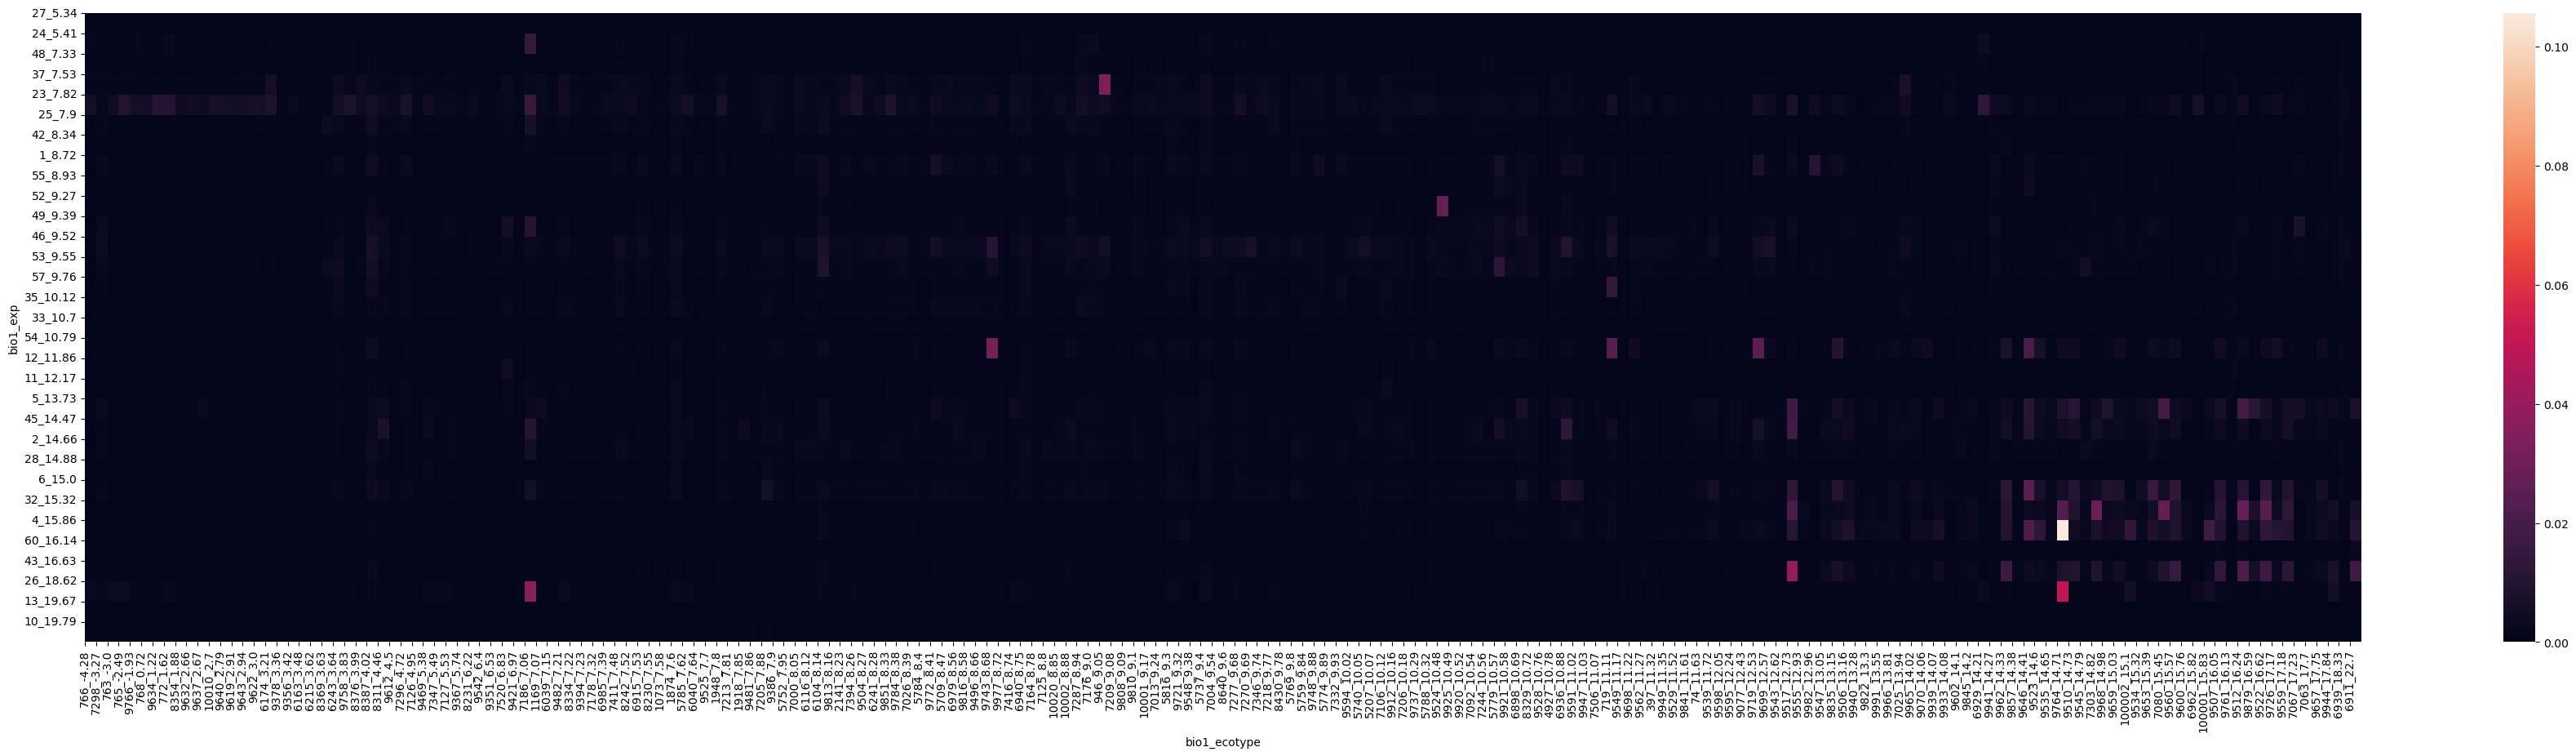

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming bioexp_vs_bioecotype is your DataFrame
plt.figure(figsize=(45, 10))  # Adjust the figure size as needed

# Create the heatmap
ax = sns.heatmap(bioexp_vs_bioecotype)

# Set x-tick labels with rotation for better visibility
ax.set_xticks(range(len(bioexp_vs_bioecotype.columns)))  # Set ticks for each column
ax.set_xticklabels(bioexp_vs_bioecotype.columns, rotation=90)  # Rotate labels for readability

# Optional: Set y-tick labels if needed
ax.set_yticks(range(len(bioexp_vs_bioecotype.index)))
ax.set_yticklabels(bioexp_vs_bioecotype.index)

# Show the plot
plt.show()


In [282]:
pseudo_prs_exon3 = pd.read_csv('pseudo_prs_exon3_grenenet.csv')

In [283]:
pseudo_prs_exon3.dtypes

index          int64
0              int64
ecotypeid      int64
bio1         float64
dtype: object

In [284]:
pseudo_prs_exon3['bio1_ecotype'] = pseudo_prs_exon3['ecotypeid'].astype(str) + '_' +  pseudo_prs_exon3['bio1'].round(2).astype(str)

In [285]:
pseudo_prs_exon3 = pseudo_prs_exon3.drop('index',axis=1)

In [286]:
pseudo_prs_exon3.columns = ['psuedo_prs', 'ecotypeid', 'bio1', 'bio1_ecotype']

In [287]:
pseudo_prs_exon3[['psuedo_prs', 'bio1_ecotype']]

,psuedo_prs,bio1_ecotype
0,16,100001_15.83
1,0,100002_15.1
2,0,10002_8.88
3,2,10006_11.32
4,6,10011_7.7
...,...,...
224,2,9947_11.03
225,2,9965_14.02
226,0,9966_13.81
227,14,9978_8.72


In [288]:
bioexp_vs_bioecotype.T

bio1_exp,27_5.34,24_5.41,48_7.33,37_7.53,23_7.82,25_7.9,42_8.34,1_8.72,55_8.93,52_9.27,...,2_14.66,28_14.88,6_15.0,32_15.32,4_15.86,60_16.14,43_16.63,26_18.62,13_19.67,10_19.79
bio1_ecotype,,,,,,,,,,,,,,,,,,,,,
766_-4.28,0.000000,0.001702,0.001215,0.001710,0.005433,0.000937,0.000119,0.000518,0.000039,0.000049,...,0.000405,0.000312,0.000790,0.000191,0.000185,0.000093,0.000463,0.002255,0.000045,0.000100
7298_-3.27,0.000043,0.000997,0.000589,0.001771,0.001857,0.001724,0.000776,0.002351,0.000765,0.000565,...,0.001924,0.000821,0.001930,0.000423,0.000761,0.000570,0.001037,0.001380,0.000750,0.000368
763_-3.0,0.000036,0.001164,0.000813,0.001357,0.004829,0.000905,0.000253,0.000403,0.000118,0.000101,...,0.000548,0.000505,0.000582,0.000229,0.000269,0.000116,0.000419,0.003296,0.000093,0.000148
765_-2.49,0.000000,0.000973,0.000952,0.001780,0.009689,0.000601,0.000217,0.000403,0.000073,0.000071,...,0.000515,0.000360,0.000606,0.000294,0.000294,0.000218,0.000299,0.004197,0.000035,0.000110
9766_-1.93,0.000000,0.002004,0.001319,0.001930,0.005629,0.000688,0.000100,0.000404,0.000050,0.000048,...,0.000384,0.000405,0.000849,0.000101,0.000189,0.000092,0.000266,0.001506,0.000065,0.000112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7063_17.7,0.000014,0.000184,0.000332,0.000445,0.000804,0.000421,0.000875,0.000773,0.000550,0.000433,...,0.000706,0.000229,0.001264,0.002261,0.002414,0.000637,0.001856,0.001145,0.000126,0.000089
9657_17.75,0.000000,0.000503,0.000336,0.001041,0.001601,0.000722,0.000862,0.001364,0.001494,0.000642,...,0.001466,0.000587,0.005668,0.003311,0.004935,0.000758,0.003061,0.001333,0.000265,0.000151
9944_17.84,0.000000,0.000000,0.000038,0.000075,0.000321,0.000094,0.000388,0.000326,0.000340,0.000098,...,0.000237,0.000049,0.000793,0.005445,0.003152,0.000223,0.007429,0.005754,0.000030,0.000000


In [289]:
pseudo_prs_exon3[['psuedo_prs', 'bio1_ecotype']]

,psuedo_prs,bio1_ecotype
0,16,100001_15.83
1,0,100002_15.1
2,0,10002_8.88
3,2,10006_11.32
4,6,10011_7.7
...,...,...
224,2,9947_11.03
225,2,9965_14.02
226,0,9966_13.81
227,14,9978_8.72


In [290]:
merged_df = pseudo_prs_exon3[['psuedo_prs', 'bio1_ecotype']].set_index('bio1_ecotype').join(bioexp_vs_bioecotype.T)

In [291]:
merged_df

,psuedo_prs,27_5.34,24_5.41,48_7.33,37_7.53,23_7.82,25_7.9,42_8.34,1_8.72,55_8.93,...,2_14.66,28_14.88,6_15.0,32_15.32,4_15.86,60_16.14,43_16.63,26_18.62,13_19.67,10_19.79
bio1_ecotype,,,,,,,,,,,,,,,,,,,,,
100001_15.83,16,0.000275,0.000378,0.000332,0.000433,0.000674,0.000463,0.000649,0.000818,0.000741,...,0.000514,0.000374,0.001386,0.002698,0.017658,0.000767,0.002281,0.005192,0.000372,0.000275
100002_15.1,0,0.000268,0.000388,0.000354,0.000498,0.000738,0.000474,0.000696,0.000800,0.000736,...,0.000590,0.000425,0.001439,0.002947,0.013299,0.000811,0.001886,0.005589,0.000349,0.000324
10002_8.88,0,0.000014,0.000865,0.000559,0.001299,0.002407,0.002682,0.001020,0.002158,0.002838,...,0.002280,0.000994,0.002212,0.001016,0.001396,0.000608,0.001864,0.001333,0.000623,0.000199
10006_11.32,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10011_7.7,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9947_11.03,2,0.000000,0.000000,0.000046,0.000049,0.000139,0.000044,0.000154,0.000105,0.000117,...,0.000224,0.000022,0.000237,0.000710,0.000703,0.000068,0.000494,0.000318,0.000000,0.000000
9965_14.02,2,0.000022,0.000512,0.000398,0.000940,0.001523,0.000743,0.000905,0.001368,0.001357,...,0.001477,0.000624,0.003929,0.002827,0.003899,0.000653,0.002424,0.001499,0.000241,0.000158
9966_13.81,0,0.000000,0.000639,0.000616,0.001273,0.001804,0.001078,0.001123,0.001551,0.001180,...,0.001888,0.000855,0.003061,0.002168,0.002691,0.000628,0.001887,0.001198,0.000293,0.000206


In [292]:
merged_df = merged_df.dropna()

In [293]:
merged_df

,psuedo_prs,27_5.34,24_5.41,48_7.33,37_7.53,23_7.82,25_7.9,42_8.34,1_8.72,55_8.93,...,2_14.66,28_14.88,6_15.0,32_15.32,4_15.86,60_16.14,43_16.63,26_18.62,13_19.67,10_19.79
bio1_ecotype,,,,,,,,,,,,,,,,,,,,,
100001_15.83,16,0.000275,0.000378,0.000332,0.000433,0.000674,0.000463,0.000649,0.000818,0.000741,...,0.000514,0.000374,0.001386,0.002698,0.017658,0.000767,0.002281,0.005192,0.000372,0.000275
100002_15.1,0,0.000268,0.000388,0.000354,0.000498,0.000738,0.000474,0.000696,0.000800,0.000736,...,0.000590,0.000425,0.001439,0.002947,0.013299,0.000811,0.001886,0.005589,0.000349,0.000324
10002_8.88,0,0.000014,0.000865,0.000559,0.001299,0.002407,0.002682,0.001020,0.002158,0.002838,...,0.002280,0.000994,0.002212,0.001016,0.001396,0.000608,0.001864,0.001333,0.000623,0.000199
5784_8.4,0,0.000101,0.000496,0.000480,0.001052,0.001315,0.000873,0.000664,0.001513,0.001005,...,0.001277,0.000498,0.000940,0.000638,0.000807,0.000656,0.000806,0.000809,0.000188,0.000149
6040_7.64,0,0.000086,0.000585,0.000804,0.000963,0.001718,0.000968,0.000656,0.001705,0.000746,...,0.000942,0.000501,0.001091,0.000404,0.000509,0.000335,0.000655,0.000528,0.000215,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9941_14.27,0,0.000000,0.000915,0.000753,0.001126,0.004260,0.001702,0.000914,0.002422,0.002320,...,0.001955,0.001177,0.002050,0.001017,0.001202,0.000585,0.001473,0.001025,0.000498,0.000243
9944_17.84,14,0.000000,0.000000,0.000038,0.000075,0.000321,0.000094,0.000388,0.000326,0.000340,...,0.000237,0.000049,0.000793,0.005445,0.003152,0.000223,0.007429,0.005754,0.000030,0.000000
9947_11.03,2,0.000000,0.000000,0.000046,0.000049,0.000139,0.000044,0.000154,0.000105,0.000117,...,0.000224,0.000022,0.000237,0.000710,0.000703,0.000068,0.000494,0.000318,0.000000,0.000000


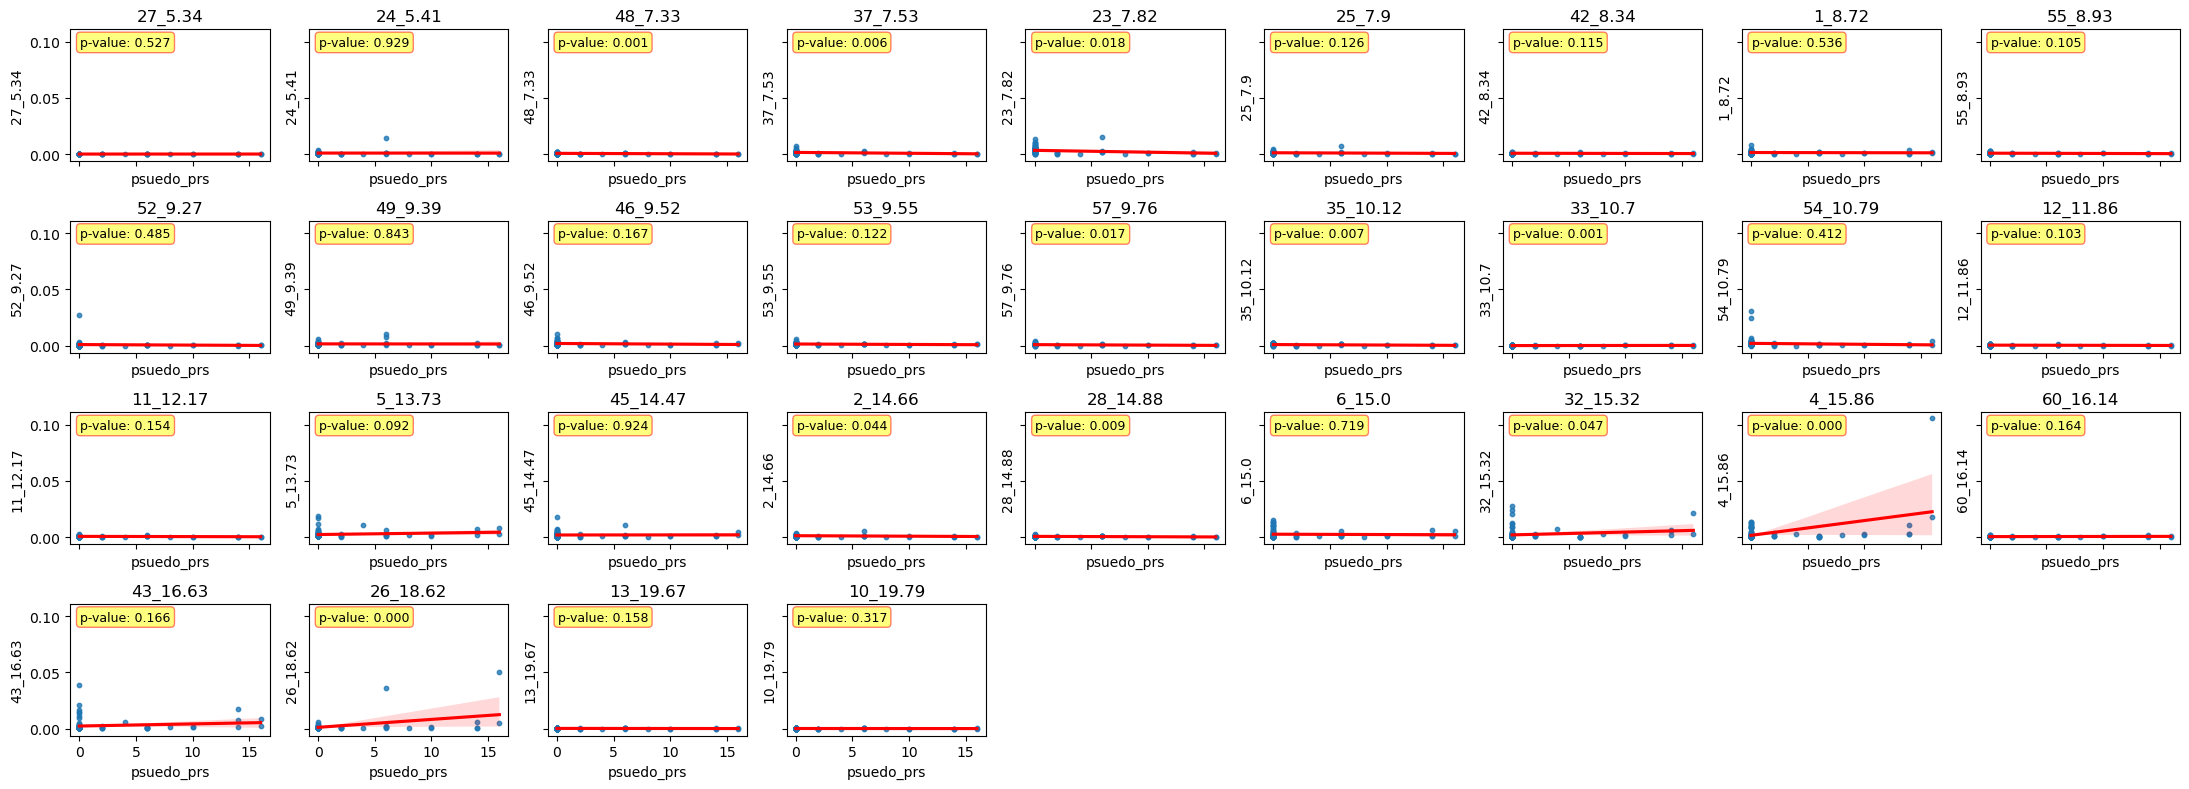

In [296]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# Set up the figure and axes
fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(22, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through the columns you want to plot against 'pseudo_prs'
for i, col in enumerate(merged_df.columns[1:]):
    # Prepare data for regression
    x = merged_df['psuedo_prs'].values  # Predictor
    y = merged_df[col].values  # Response
    x = sm.add_constant(x)  # Adds a constant term to the predictor
    
    # Perform regression
    model = sm.OLS(y, x, missing='drop')  # OLS regression, excluding NaNs
    results = model.fit()
    
    # Extract slope and p-value
    slope = results.params[1]
    p_value = results.pvalues[1]
    
    # Create a regplot on the appropriate subplot
    sns.regplot(data=merged_df, x='psuedo_prs', y=col, ax=axes[i], scatter_kws={'s': 10}, line_kws={'color': 'red'})
    
    # Annotate the plot with slope and p-value
    annotation = f'p-value: {p_value:.3f}'
    axes[i].annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))
    
    # Set the title to the column name for clarity
    axes[i].set_title(f'{col}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Show the plot
plt.show()


In [299]:
pseudo_prs_exon3

,psuedo_prs,ecotypeid,bio1,bio1_ecotype
0,16,100001,15.829166,100001_15.83
1,0,100002,15.100000,100002_15.1
2,0,10002,8.879167,10002_8.88
3,2,10006,11.320833,10006_11.32
4,6,10011,7.704167,10011_7.7
...,...,...,...,...
224,2,9947,11.029166,9947_11.03
225,2,9965,14.025000,9965_14.02
226,0,9966,13.812500,9966_13.81
227,14,9978,8.716667,9978_8.72


In [302]:
result

,plot,site,generation,ecotype,freq,bio1_ecotype,bio1_exp
0,1,1,1,10002,0.001811,8.88,8.72
1,2,1,1,10002,0.002972,8.88,8.72
2,3,1,1,10002,0.002207,8.88,8.72
3,4,1,1,10002,0.002224,8.88,8.72
4,5,1,1,10002,0.003074,8.88,8.72
...,...,...,...,...,...,...,...
172090,8,60,1,9992,0.000657,9.89,16.14
172091,9,60,1,9992,0.000834,9.89,16.14
172092,10,60,1,9992,0.037258,9.89,16.14
172093,11,60,1,9992,0.000362,9.89,16.14


In [304]:
result_w_prs = result.merge(pseudo_prs_exon3[['ecotypeid', 'psuedo_prs']], left_on = 'ecotype', right_on = 'ecotypeid')

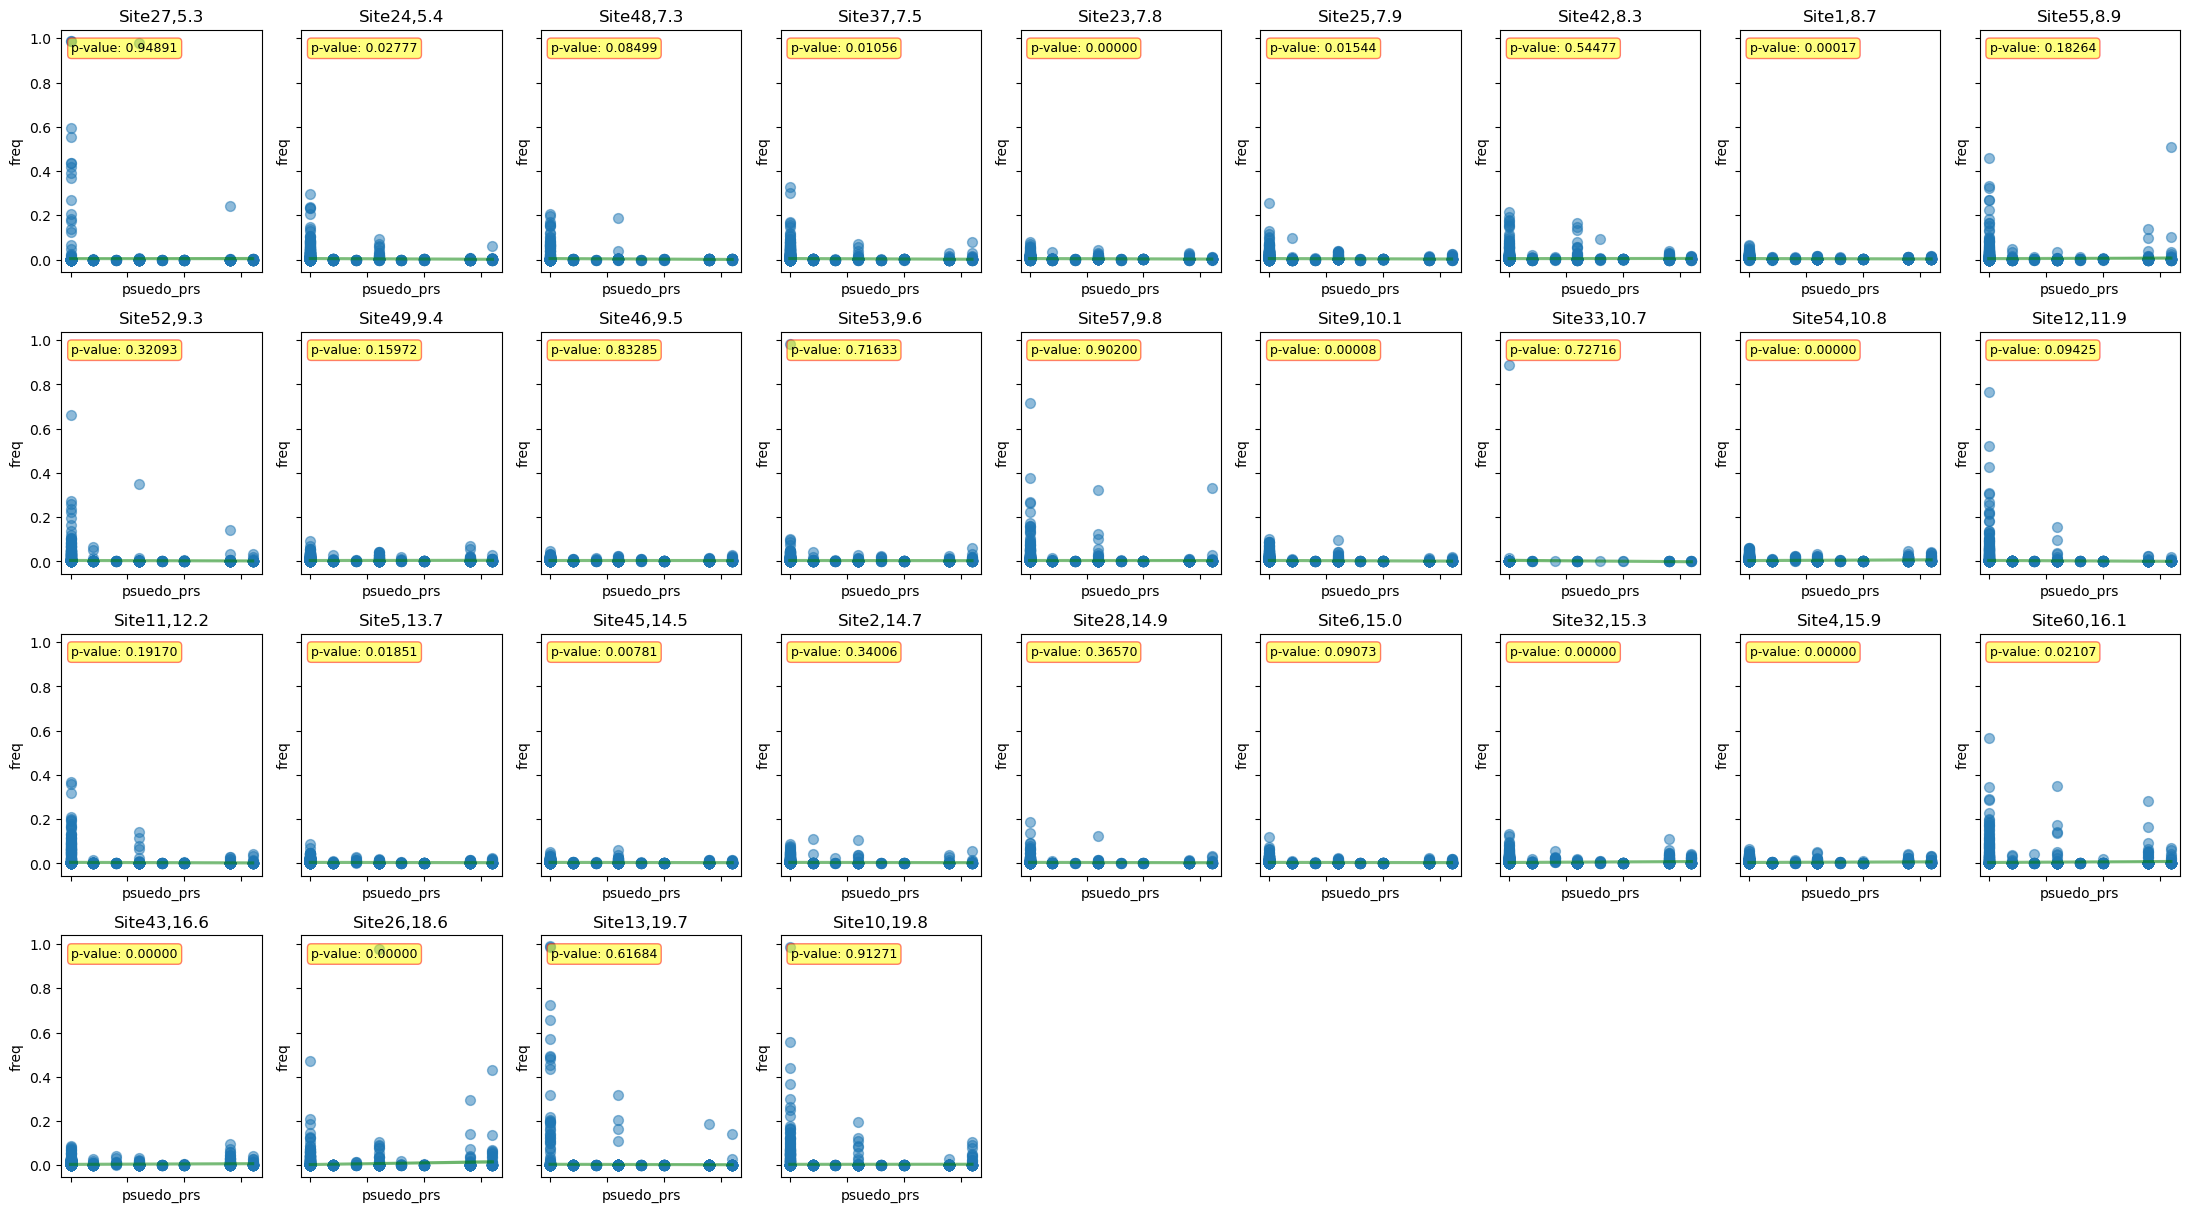

In [346]:
result_w_prsgen3 = result_w_prs[result_w_prs['generation']==1]

# Assuming result_w_prsgen3 is your DataFrame
# Step 1: Aggregate bio1_exp for each site (using mean in this example)
site_bio1_exp = result_w_prsgen3.groupby('site')['bio1_exp'].mean()

# Step 2: Sort the sites by bio1_exp
sorted_sites = site_bio1_exp.sort_values().index.tolist()

# Step 3: Determine layout for subplots
num_sites = len(sorted_sites)
num_cols = 3  # Adjust the number of columns as needed
num_rows = (num_sites + num_cols - 1) // num_cols  # Ensures enough rows

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=9, figsize=(22, 15), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the array of axes

# Loop through each sorted site and plot
for i, site in enumerate(sorted_sites):
    # Filter data for the current site
    data_filtered = result_w_prsgen3[result_w_prsgen3['site'] == site]

    # Create a scatter plot on the appropriate subplot
    sns.regplot(data=data_filtered, x='psuedo_prs', y='freq', ax=axes[i], 
                scatter_kws={"alpha": 0.5, "s": 50},  # Set alpha to 0.5 for transparency, adjust size 's' as needed
                line_kws={"color": "green","alpha": 0.5})

    # Fit linear regression model
    X = sm.add_constant(data_filtered['psuedo_prs'])  # adding a constant
    model = sm.OLS(data_filtered['freq'], X).fit()
    p_value = model.pvalues[1]  # p-value for the slope

    # Get the bio1_exp value for the title
    bio1_exp_value = site_bio1_exp.loc[site]

    # Set title with site, bio1_exp value, and p-value
    axes[i].set_title(f'Site{site},{bio1_exp_value:.1f}')
    annotation = f'p-value: {p_value:.5f}'
    axes[i].annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))
# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


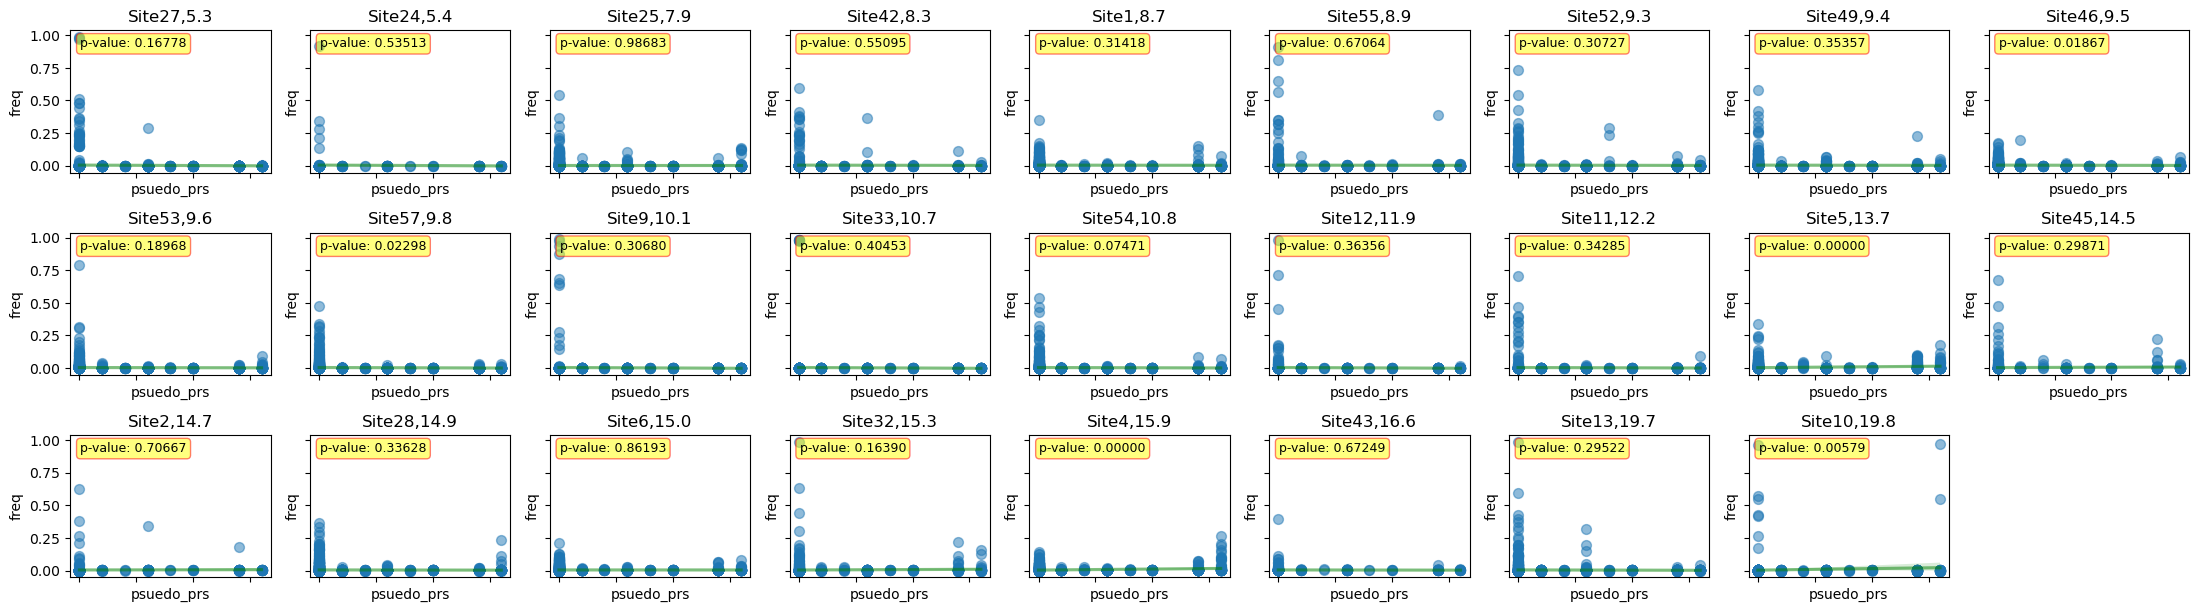

In [345]:
result_w_prsgen3 = result_w_prs[result_w_prs['generation']==2]

# Assuming result_w_prsgen3 is your DataFrame
# Step 1: Aggregate bio1_exp for each site (using mean in this example)
site_bio1_exp = result_w_prsgen3.groupby('site')['bio1_exp'].mean()

# Step 2: Sort the sites by bio1_exp
sorted_sites = site_bio1_exp.sort_values().index.tolist()

# Step 3: Determine layout for subplots
num_sites = len(sorted_sites)
num_cols = 3  # Adjust the number of columns as needed
num_rows = (num_sites + num_cols - 1) // num_cols  # Ensures enough rows

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(22, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the array of axes

# Loop through each sorted site and plot
for i, site in enumerate(sorted_sites):
    # Filter data for the current site
    data_filtered = result_w_prsgen3[result_w_prsgen3['site'] == site]

    # Create a scatter plot on the appropriate subplot
    sns.regplot(data=data_filtered, x='psuedo_prs', y='freq', ax=axes[i], 
                scatter_kws={"alpha": 0.5, "s": 50},  # Set alpha to 0.5 for transparency, adjust size 's' as needed
                line_kws={"color": "green","alpha": 0.5})

    # Fit linear regression model
    X = sm.add_constant(data_filtered['psuedo_prs'])  # adding a constant
    model = sm.OLS(data_filtered['freq'], X).fit()
    p_value = model.pvalues[1]  # p-value for the slope

    # Get the bio1_exp value for the title
    bio1_exp_value = site_bio1_exp.loc[site]

    # Set title with site, bio1_exp value, and p-value
    axes[i].set_title(f'Site{site},{bio1_exp_value:.1f}')
    annotation = f'p-value: {p_value:.5f}'
    axes[i].annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))
# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


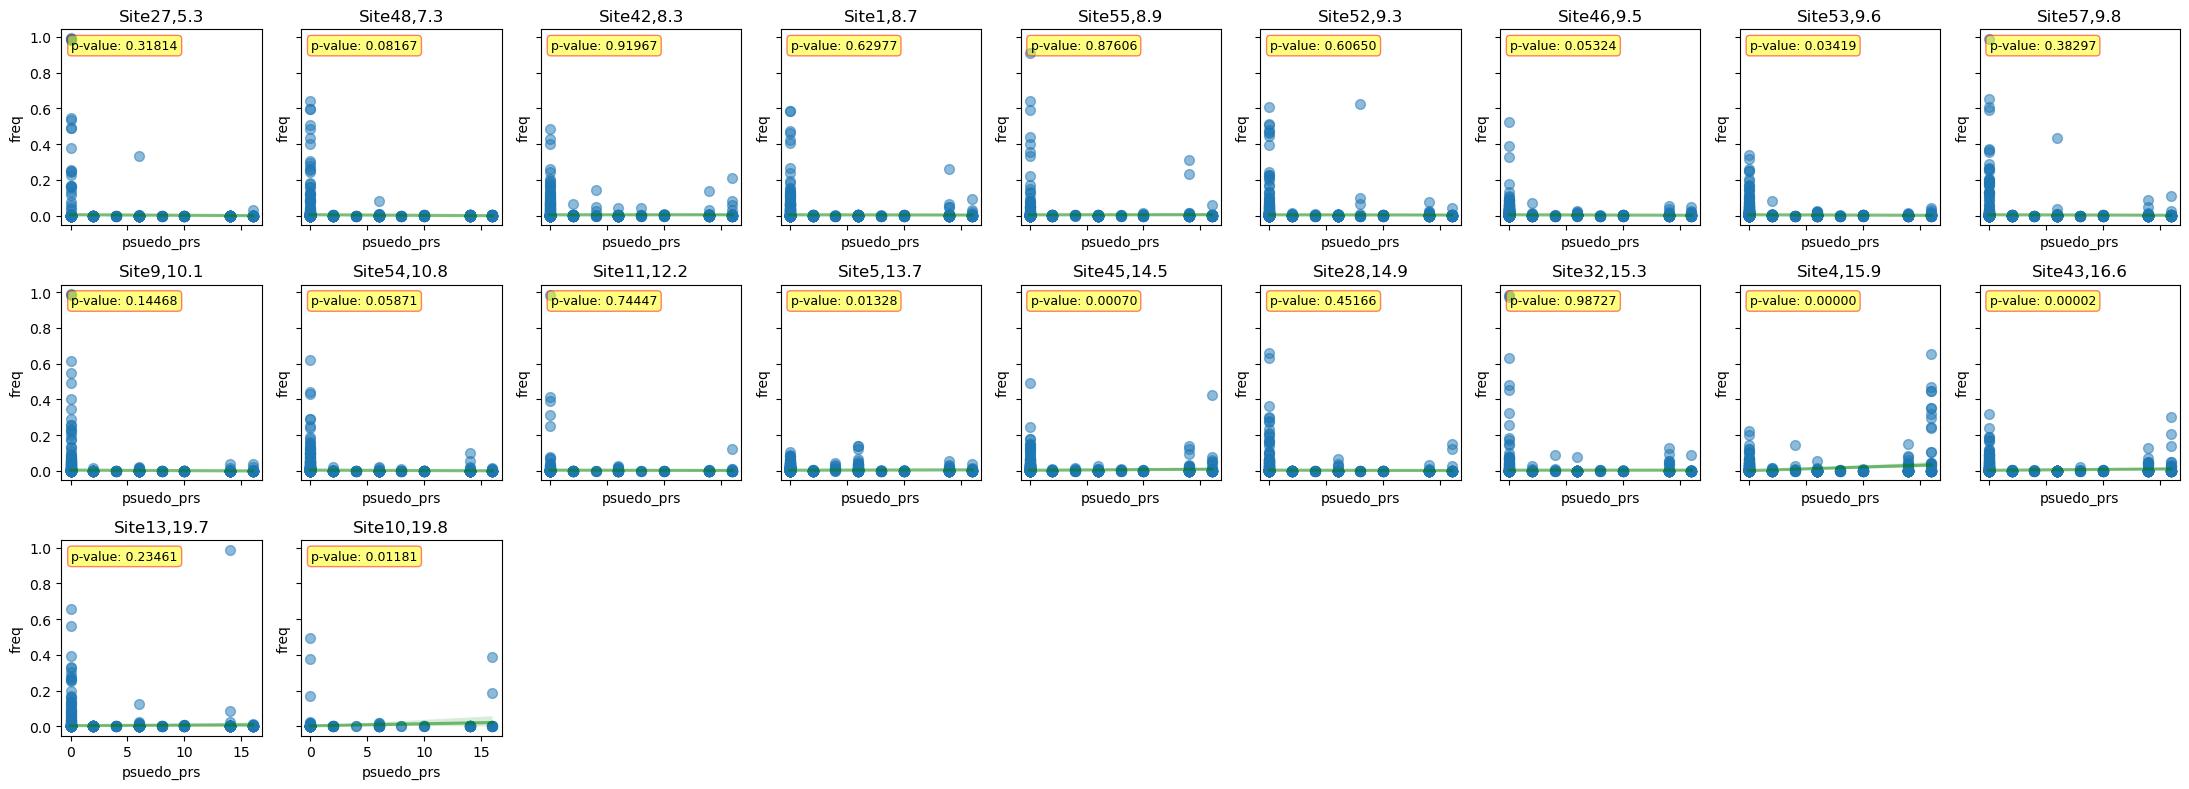

In [342]:
result_w_prsgen3 = result_w_prs[result_w_prs['generation']==3]

# Assuming result_w_prsgen3 is your DataFrame
# Step 1: Aggregate bio1_exp for each site (using mean in this example)
site_bio1_exp = result_w_prsgen3.groupby('site')['bio1_exp'].mean()

# Step 2: Sort the sites by bio1_exp
sorted_sites = site_bio1_exp.sort_values().index.tolist()

# Step 3: Determine layout for subplots
num_sites = len(sorted_sites)
num_cols = 3  # Adjust the number of columns as needed
num_rows = (num_sites + num_cols - 1) // num_cols  # Ensures enough rows

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=9, figsize=(22, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the array of axes

# Loop through each sorted site and plot
for i, site in enumerate(sorted_sites):
    # Filter data for the current site
    data_filtered = result_w_prsgen3[result_w_prsgen3['site'] == site]

    # Create a scatter plot on the appropriate subplot
    sns.regplot(data=data_filtered, x='psuedo_prs', y='freq', ax=axes[i], 
                scatter_kws={"alpha": 0.5, "s": 50},  # Set alpha to 0.5 for transparency, adjust size 's' as needed
                line_kws={"color": "green","alpha": 0.5})

    # Fit linear regression model
    X = sm.add_constant(data_filtered['psuedo_prs'])  # adding a constant
    model = sm.OLS(data_filtered['freq'], X).fit()
    p_value = model.pvalues[1]  # p-value for the slope

    # Get the bio1_exp value for the title
    bio1_exp_value = site_bio1_exp.loc[site]

    # Set title with site, bio1_exp value, and p-value
    axes[i].set_title(f'Site{site},{bio1_exp_value:.1f}')
    annotation = f'p-value: {p_value:.5f}'
    axes[i].annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))
# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# Set up the figure and axes
fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(22, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through the columns you want to plot against 'pseudo_prs'
for i, col in result_w_prsgen3['site'].unique()):
    # Prepare data for regression
    x = merged_df['psuedo_prs'].values  # Predictor
    y = merged_df[col].values  # Response
    x = sm.add_constant(x)  # Adds a constant term to the predictor
    
    # Perform regression
    model = sm.OLS(y, x, missing='drop')  # OLS regression, excluding NaNs
    results = model.fit()
    
    # Extract slope and p-value
    slope = results.params[1]
    p_value = results.pvalues[1]
    
    # Create a regplot on the appropriate subplot
    sns.regplot(data=merged_df, x='psuedo_prs', y=col, ax=axes[i], scatter_kws={'s': 10}, line_kws={'color': 'red'})
    
    # Annotate the plot with slope and p-value
    annotation = f'p-value: {p_value:.3f}'
    axes[i].annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='yellow', alpha=0.5))
    
    # Set the title to the column name for clarity
    axes[i].set_title(f'{col}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Show the plot
plt.show()